In [14]:
# setup chunk

## import libraries
import torch
import torch.nn as nn
import os
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import random
import math
import pandas as pd

## set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the CNN Model
We begin by importing the CNN model that we previously configured and trained using the MS COCO and Oxford Street datasets. To achieve this, we need to redefine the same model architecture. Once the architecture is set, we can then load the corresponding model weights.

In [3]:
# Basic block with two convolutional layers
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Overall CNN model architecture
class CNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNN, self).__init__()
        self.in_channels = 32

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Stacked layers of basic block with increasing number of filters
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        # Average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# assign the class to a model object
cnn_model = CNN(BasicBlock, [3, 4, 6, 3]).to(device)

# set the path where the trained weights are stored
model_weights_path = "/content/drive/My Drive/CNN_Model/cnn_model_weights.pth"

# load weights into the model
cnn_model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device)))

<ipython-input-3-e525cafd46c9>:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device)))

<All keys matched successfully>

### Testing Model on Earthcam Images
Next, we apply the CNN model to the Earthcam images we collected for London, New York and New Orleans. After defining the folder paths where the surveillance images are located, a preprocessing object is defined that converts the images into tensor objects and normalizes them in the same way as the training data used to train the CNN. To test the performance of the model, we visualize some example images with the corresponding predicted number of people that the model has output.

In [4]:
# define paths to image folders via dictionary
folder_paths = {
    'New York': '/content/drive/My Drive/Filtered_Images/NewYork_filtered',
    'New Orleans': '/content/drive/My Drive/Filtered_Images/NewOrleans_filtered',
    'London': '/content/drive/My Drive/Filtered_Images/London_filtered'
}

In [7]:
def resize_and_pad(image_path, desired_size=128):
    # Open an image file
    with Image.open(image_path) as img:
        # Resize the image while keeping the aspect ratio
        img.thumbnail((desired_size, desired_size))

        # Create a new image with a black background
        new_image = Image.new("RGB", (desired_size, desired_size), (0, 0, 0))

        # Calculate the position to paste the resized image onto the new image
        paste_position = (
            (desired_size - img.size[0]) // 2,
            (desired_size - img.size[1]) // 2
        )

        # Paste the resized image onto the new image
        new_image.paste(img, paste_position)

        return new_image

def process_images(folder_path, output_folder):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Process each image in the directory
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            output_path = os.path.join(output_folder, filename)
            # Resize and pad the image
            img = resize_and_pad(image_path)
            # Save the processed image
            img.save(output_path)

In [11]:
# Define the path to the London folder
NewYork_folder = '/content/drive/My Drive/Filtered_Images/NewYork_filtered'

# Process the images
process_images(NewYork_folder, NewYork_folder)

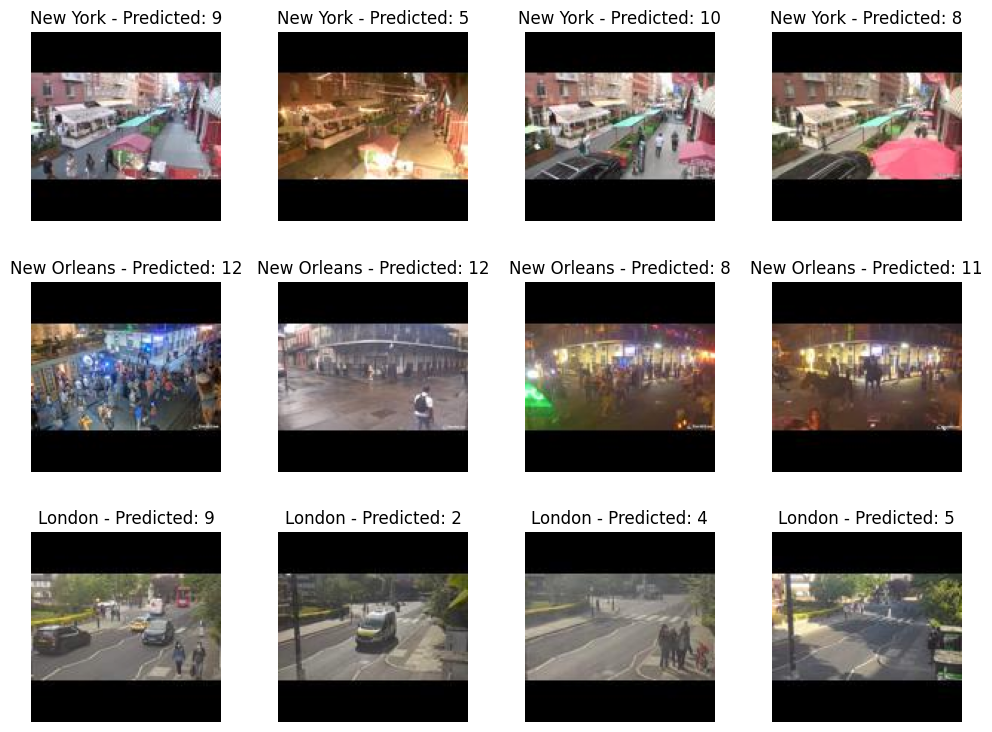

In [12]:
# define image preprocessing steps
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# visualize how model works on the images
def visualize_prediction(model, year, number_of_images_per_city=2):
    model.eval()

    all_image_files = [] # empty list where images to visualize are stored

    # loop through all image directories
    for city, image_dir in folder_paths.items():
        city_image_files = []

        # loop through all image filenames in each directory
        for filename in os.listdir(image_dir):
            if filename.endswith(".jpg"):
                parts = filename.split('_')
                date = parts[1] # extract the date
                file_year = date.split('-')[-1] # extract the year
                if file_year == year:
                    city_image_files.append((city, filename)) # append to list if year matches with the year selected

        # randomly select the specified number of images for this city
        selected_images = random.sample(city_image_files, number_of_images_per_city)
        # append these images to the list with all images
        all_image_files.extend(selected_images)

    # calculate the number of rows and columns based on the total number of images to visualize
    total_images = len(all_image_files)
    rows = math.ceil(total_images / 4)
    cols = min(4, total_images)

    # create the plot
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # loop through the list with all image files
    for i, (city, filename) in enumerate(all_image_files):
        image_dir = folder_paths[city]
        image_path = os.path.join(image_dir, filename)

        # load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image = preprocess(image).unsqueeze(0).to(device)

        # predict the people count using the model
        predicted_count = model(image)
        predicted_count = torch.round(predicted_count).item()

        # convert tensor to numpy for display
        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)

        # undo the normalization for visualization purposes
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

        # determine the correct axis for single or multiple rows/columns
        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]

        # display the image with title showing city and predicted count
        ax.imshow(image_np)
        ax.set_title(f"{city} - Predicted: {int(predicted_count)}")
        ax.axis('off')

    plt.show()

# visualize the prediction for images from each city
visualize_prediction(cnn_model, "2022", number_of_images_per_city=4)

In [15]:
# Define paths to image folders via dictionary
folder_paths = {
    'New York': '/content/drive/My Drive/Filtered_Images/NewYork_filtered',
    'New Orleans': '/content/drive/My Drive/Filtered_Images/NewOrleans_filtered',
    'London': '/content/drive/My Drive/Filtered_Images/London_filtered'
}

# Define paths to ground truth CSV files
ground_truth_csv_paths = {
    'New York': '/content/drive/My Drive/Manual_Annotations/ground_truth_New_York.csv',
    'New Orleans': '/content/drive/My Drive/Manual_Annotations/ground_truth_New_Orleans.csv',
    'London': '/content/drive/My Drive/Manual_Annotations/ground_truth_London.csv'
}

# Loop through all image directories
for city, image_dir in folder_paths.items():
    city_image_files = []

    # Load the ground truth data from CSV
    ground_truth_df = pd.read_csv(ground_truth_csv_paths[city])

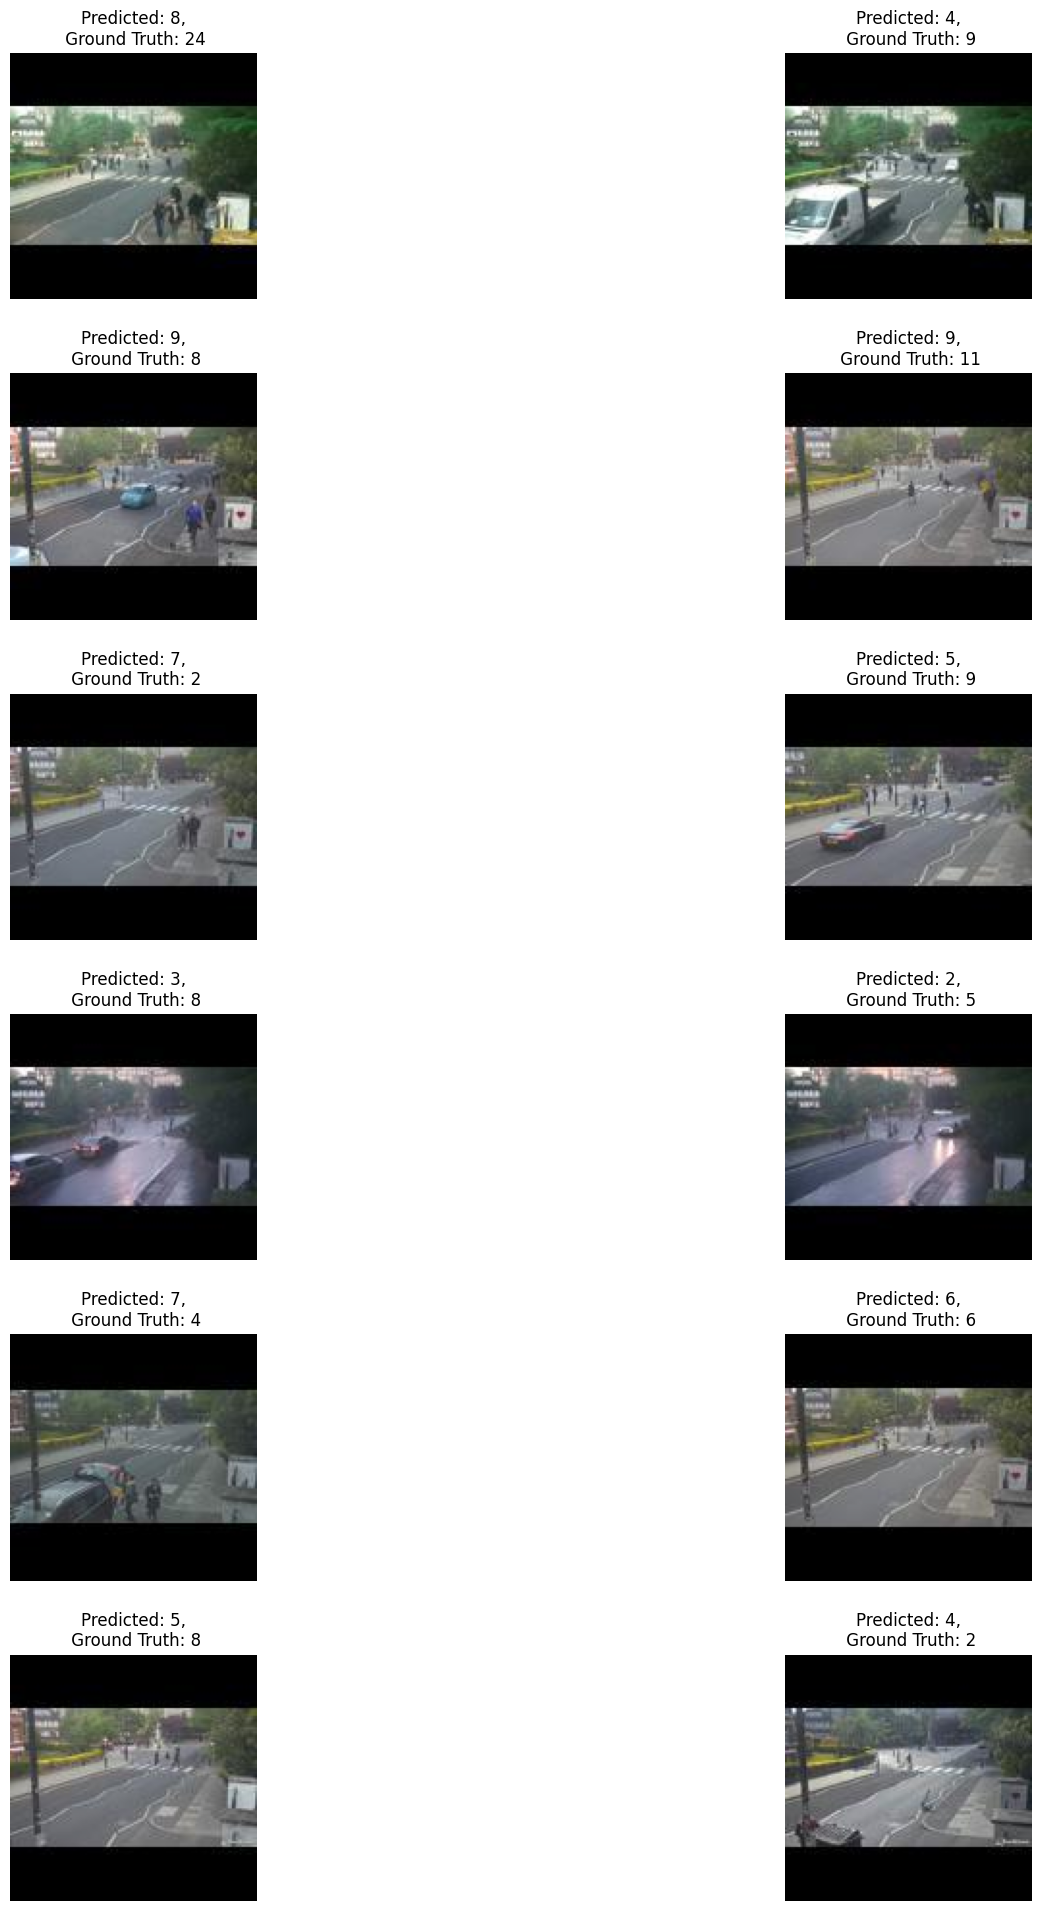

In [16]:
import csv

def load_ground_truth(file_path):
    ground_truth = {}
    with open(file_path, mode='r') as file:
        if file_path.endswith('.csv'):
            reader = csv.reader(file)
            next(reader)  # Skip the header
            for row in reader:
                filename, count = row
                ground_truth[filename] = int(count)
        elif file_path.endswith('.json'):
            ground_truth = json.load(file)
    return ground_truth

def visualize_ground_truth_predictions(model, ground_truth_file, city):
    # Load the ground truth data
    ground_truth = load_ground_truth(ground_truth_file)

    # Set the directory where images are stored
    image_dir = folder_paths[city]

    # Determine the number of images
    number_of_images = len(ground_truth)

    # Set up the plot grid
    rows = math.ceil(number_of_images / 2)
    cols = min(2, number_of_images)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.0)

    for i, (filename, gt_count) in enumerate(ground_truth.items()):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image = preprocess(image).unsqueeze(0).to(device)

        # Predict using the model
        predicted_count = model(image)
        predicted_count = torch.round(predicted_count).item()

        # Convert tensor to numpy for display
        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])


        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]

        ax.imshow(image_np)
        ax.set_title(f"Predicted: {int(predicted_count)},\n Ground Truth: {gt_count}")
        ax.axis('off')

    plt.show()

# Example usage:
visualize_ground_truth_predictions(cnn_model, '/content/drive/My Drive/Manual_Annotations/ground_truth_London_filtered.csv', "London")

### Main Analysis
Now that we have seen how the CNN works in different situations, we come to the main part of the analysis. Here we predict the number of people for all the images we have collected for all three cities. Next, we take the average of the individual days per city per year. This is to model a trend of how the number of people has evolved over time. By calculating the mean value, we want to minimize the problem that the images were taken at very different times of day and do not always show exactly the same camera angle. Averaging over the number of images should therefore make our results more robust to this randomness.

In [19]:
# create a dictionary storing all cities, years and dates to store counts there
results = {
    "London": {
        "2019": {"05-01-2019": [], "05-02-2019": [], "05-03-2019": [], "05-04-2019": [],
                 "05-05-2019": [], "05-06-2019": [], "05-07-2019": [], "05-08-2019": [],
                 "05-09-2019": [], "05-10-2019": [], "05-11-2019": [], "05-12-2019": [],
                 "05-13-2019": [], "05-14-2019": []},
        "2020": {"05-01-2020": [], "05-02-2020": [], "05-03-2020": [], "05-04-2020": [],
                 "05-05-2020": [], "05-06-2020": [], "05-07-2020": [], "05-08-2020": [],
                 "05-09-2020": [], "05-10-2020": [], "05-11-2020": [], "05-12-2020": [],
                 "05-13-2020": [], "05-14-2020": []},
        "2022": {"05-01-2022": [], "05-02-2022": [], "05-03-2022": [], "05-04-2022": [],
                 "05-05-2022": [], "05-06-2022": [], "05-07-2022": [], "05-08-2022": [],
                 "05-09-2022": [], "05-10-2022": [], "05-11-2022": [], "05-12-2022": [],
                 "05-13-2022": [], "05-14-2022": []}
    },
    "New York": {
        "2019": {"06-16-2019": [], "06-17-2019": [], "06-18-2019": [], "06-19-2019": [],
                 "06-20-2019": [], "06-21-2019": [], "06-22-2019": [], "06-23-2019": [],
                 "06-24-2019": [], "06-25-2019": [], "06-26-2019": [], "06-27-2019": [],
                 "06-28-2019": [], "06-29-2019": []},
        "2020": {"06-16-2020": [], "06-17-2020": [], "06-18-2020": [], "06-19-2020": [],
                 "06-20-2020": [], "06-21-2020": [], "06-22-2020": [], "06-23-2020": [],
                 "06-24-2020": [], "06-25-2020": [], "06-26-2020": [], "06-27-2020": [],
                 "06-28-2020": [], "06-29-2020": []},
        "2022": {"06-16-2022": [], "06-17-2022": [], "06-18-2022": [], "06-19-2022": [],
                 "06-20-2022": [], "06-21-2022": [], "06-22-2022": [], "06-23-2022": [],
                 "06-24-2022": [], "06-25-2022": [], "06-26-2022": [], "06-27-2022": [],
                 "06-28-2022": [], "06-29-2022": []}
    },
    "New Orleans": {
        "2019": {"05-13-2019": [], "05-14-2019": [], "05-15-2019": [], "05-16-2019": [],
                 "05-17-2019": [], "05-18-2019": [], "05-19-2019": [], "05-20-2019": [],
                 "05-21-2019": [], "05-22-2019": [], "05-23-2019": [], "05-24-2019": [],
                 "05-25-2019": [], "05-26-2019": []},
        "2020": {"05-13-2020": [], "05-14-2020": [], "05-15-2020": [], "05-16-2020": [],
                 "05-17-2020": [], "05-18-2020": [], "05-19-2020": [], "05-20-2020": [],
                 "05-21-2020": [], "05-22-2020": [], "05-23-2020": [], "05-24-2020": [],
                 "05-25-2020": [], "05-26-2020": []},
        "2022": {"05-13-2022": [], "05-14-2022": [], "05-15-2022": [], "05-16-2022": [],
                 "05-17-2022": [], "05-18-2022": [], "05-19-2022": [], "05-20-2022": [],
                 "05-21-2022": [], "05-22-2022": [], "05-23-2022": [], "05-24-2022": [],
                 "05-25-2022": [], "05-26-2022": []}
    }
}


# define function that predicts the people count per image
def predict_image(image, model):
    model.eval() # set the model to evaluation mode
    image = preprocess(image).unsqueeze(0).to(device) # adding extra dimension for batch size of 1 (just one image no data loader)
    with torch.no_grad():
        count = model(image) # get the predicted count
        count = torch.round(count).item() # round the float to get a valid count
    return count

# loop through all city paths in the dictionary
for city, path in folder_paths.items():

    # loop through all images per image directory
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            parts = filename.split('_')
            city_name = parts[0] # extract the city name
            date = parts[1] # extract the date
            year = date.split('-')[-1] # extract the year
            image_path = os.path.join(path, filename)
            image = Image.open(image_path).convert('RGB') # open the image via path
            count = predict_image(image, cnn_model) # get the count per image by applying the function

            # store count in the dictionary
            if year in results[city]:
                results[city][year][date].append(count)


averages = {} # define empty dictionary to store average counts per day

# loop through all cities and years
for city, years in results.items():
    averages[city] = {} # store city in the averages dictionary
    for year, days in years.items(): # loop through years
        averages[city][year] = {} # store year in the averages dictionary
        for day, counts in days.items(): # loop through all days
            avg_count = sum(counts) / len(counts) # get the average count per day
            averages[city][year][day] = avg_count # store average day count in the averages dictionary

In a final step, we visualize our results in three graphs (one per city) that show the development of the average number of people counted per day. For each city, the graph shows the same two weeks in 2019, 2020 and 2022. The first week in 2020 corresponds to a period in which the city in question was in lockdown. In the second week of 2022, this lockdown was eased again. We have shaded the corresponding areas red for the lockdown and green for the period in which this lockdown has already been eased to a certain extent.

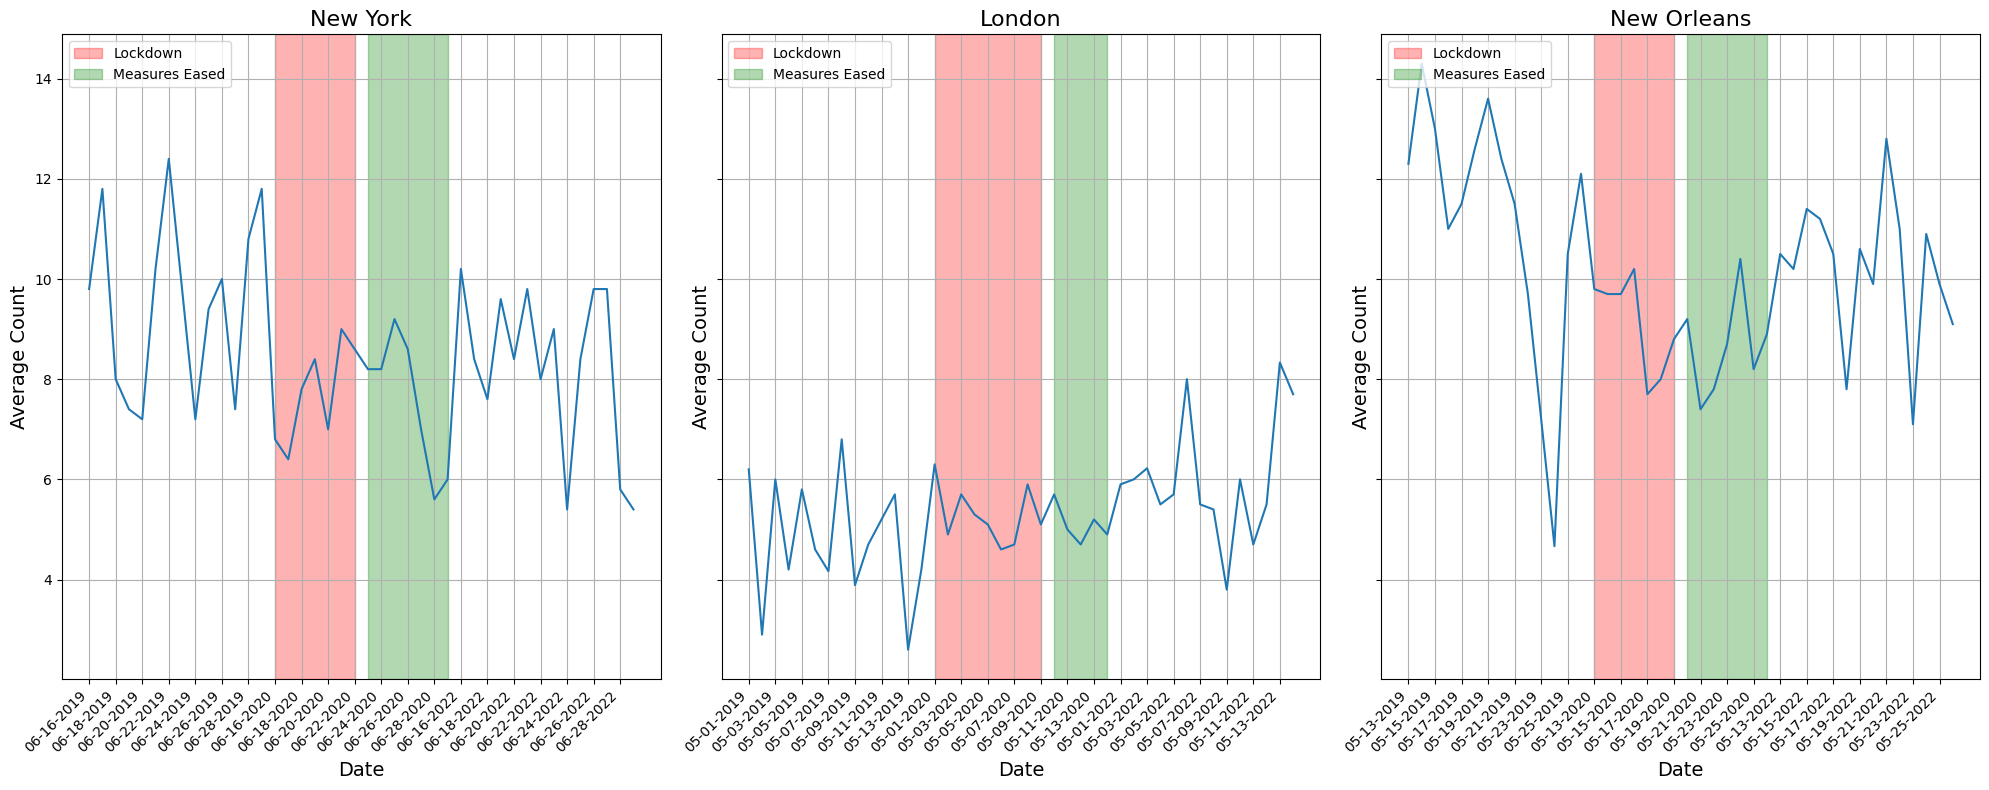

In [20]:
# function to flatten the averages dictionary for later visualization
def flatten_averages(averages):
    flattened = [] # define empty list to store the results
    # loop through all cities
    for city, years in averages.items():
        # loop through all years
        for year, date in years.items():
            # loop through all days
            for date, avg_count in date.items():
                # append count tuple to the flattened list
                flattened.append((city, date, avg_count))
    return flattened

data = flatten_averages(averages) # apply the function

# create plot to show trajectories of predicted counts
fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharex=False, sharey=True)

cities = ['New York', 'London', 'New Orleans']

# define dates marking lockdown and period in which lockdown was eased
lockdown_first_date = {"London": "05-01-2020",
                    "New York": "06-16-2020",
                    "New Orleans": "05-13-2020"}
lockdown_last_date = {"London": "05-09-2020",
                   "New York": "06-22-2020",
                   "New Orleans": "05-19-2020"}
lockdowneasing_first_date = {"London": "05-10-2020",
                           "New York": "06-23-2020",
                           "New Orleans": "05-20-2020"}
lockdowneasing_last_date = {"London": "05-14-2020",
                           "New York": "06-29-2020",
                           "New Orleans": "05-26-2020"}

# loop through all cities
for i, city in enumerate(cities):
    # create list per city with date and the average count
    city_data = [(date, avg_count) for c, date, avg_count in data if c == city]

    if city_data:
        dates, counts = zip(*city_data) # unzip the tuple objects
        axs[i].plot(dates, counts)
        axs[i].set_title(f'{city}', fontsize=16)
        axs[i].set_xlabel('Date', fontsize=14)
        axs[i].set_ylabel('Average Count', fontsize=14)
        axs[i].grid(True)
        axs[i].set_xticks(dates[::len(dates)//21]) # show only every second date
        plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45, ha='right') # rotate the x axis ticks for visualization
        axs[i].axvspan(lockdown_first_date[city], lockdown_last_date[city], color="red", alpha=0.3, label="Lockdown") # shaded area for lockdown period
        axs[i].axvspan(lockdowneasing_first_date[city], lockdowneasing_last_date[city], color="green", alpha=0.3, label="Measures Eased") # shaded area for period in which measures were eased
        axs[i].legend(loc='upper left') # set the legend

plt.tight_layout()
plt.show()

## Final Visualization

In [21]:
def load_ground_truth(file_path):
    ground_truth = {}
    with open(file_path, mode='r') as file:
        if file_path.endswith('.csv'):
            reader = csv.reader(file)
            next(reader)  # Skip the header
            for row in reader:
                filename, count = row
                ground_truth[filename] = int(count)
        elif file_path.endswith('.json'):
            ground_truth = json.load(file)
    return ground_truth

def extract_date_from_filename(filename):
    # Split the filename to get the date
    parts = filename.split('_')
    if len(parts) >= 2:
        date_part = parts[1]
        # Convert the date part into a datetime object
        date_obj = datetime.strptime(date_part, "%m-%d-%Y")
        return date_obj
    return None

def visualize_ground_truth_predictions(model, ground_truth_file, city, predictions_dict):
    # Load the ground truth data
    ground_truth = load_ground_truth(ground_truth_file)

    # Extract and sort filenames by date
    sorted_ground_truth = sorted(ground_truth.items(), key=lambda item: extract_date_from_filename(item[0]))

    # Set the directory where images are stored
    image_dir = folder_paths[city]

    # Determine the number of images
    number_of_images = len(sorted_ground_truth)

    # Set up the plot grid
    rows = math.ceil(number_of_images / 3)
    cols = min(3, number_of_images)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.0)

    for i, (filename, gt_count) in enumerate(sorted_ground_truth):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image = preprocess(image).unsqueeze(0).to(device)

        # Predict using the model
        predicted_count = model(image)
        predicted_count = torch.round(predicted_count).item()

        # Store predictions and ground truth in the dictionary
        predictions_dict[filename] = {'ground_truth': gt_count, 'predicted': int(predicted_count)}

        # Convert tensor to numpy for display
        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

        # Extract the date from the filename
        date = extract_date_from_filename(filename).strftime("%m-%d-%Y")

        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]

        ax.imshow(image_np)
        ax.set_title(f"Date: {date}\nPredicted: {int(predicted_count)}, Ground Truth: {gt_count}")
        ax.axis('off')

    plt.show()

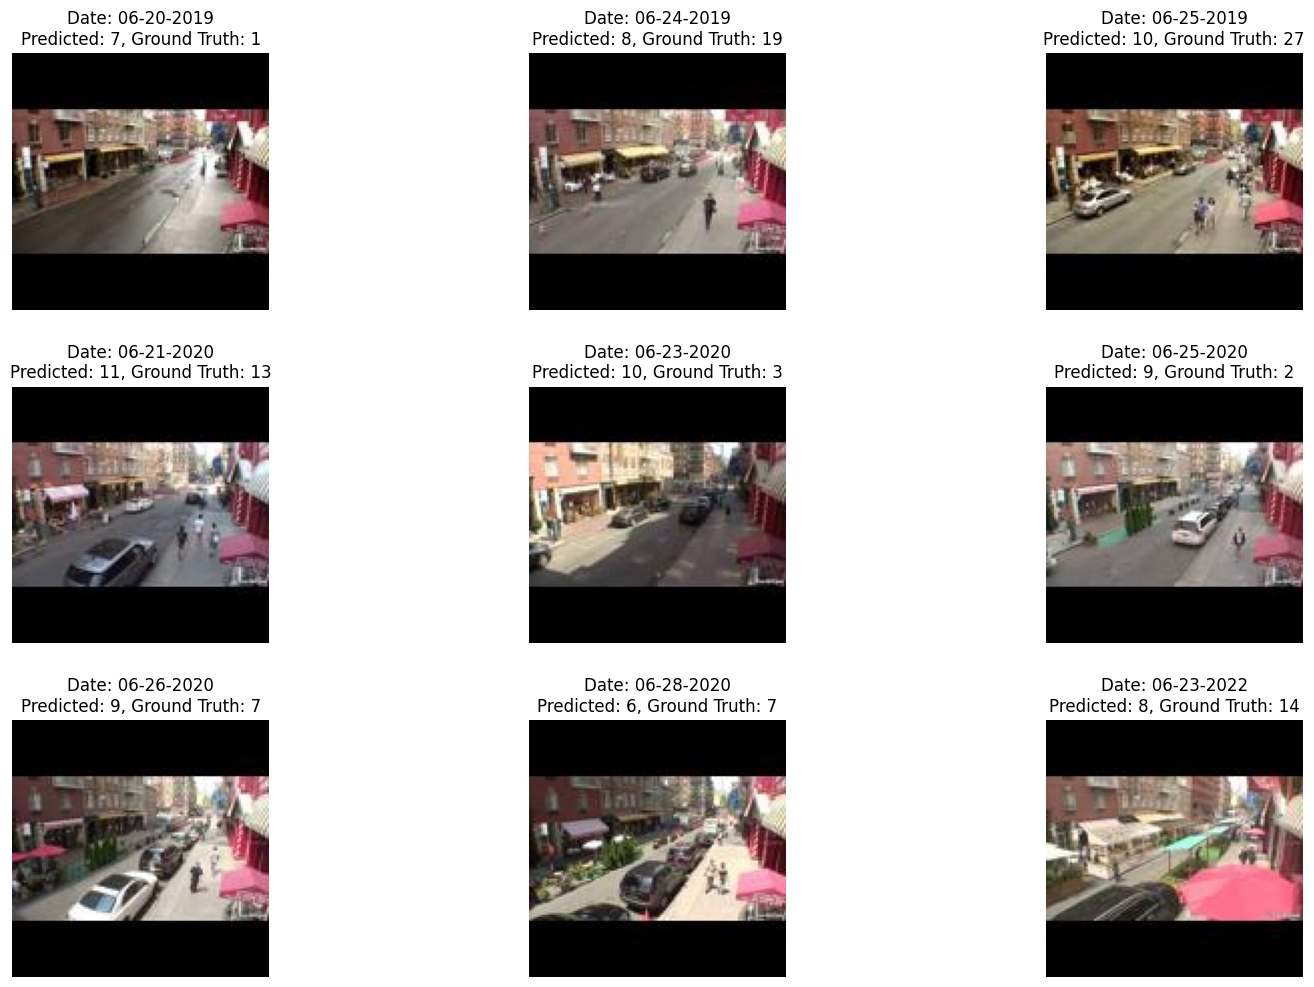

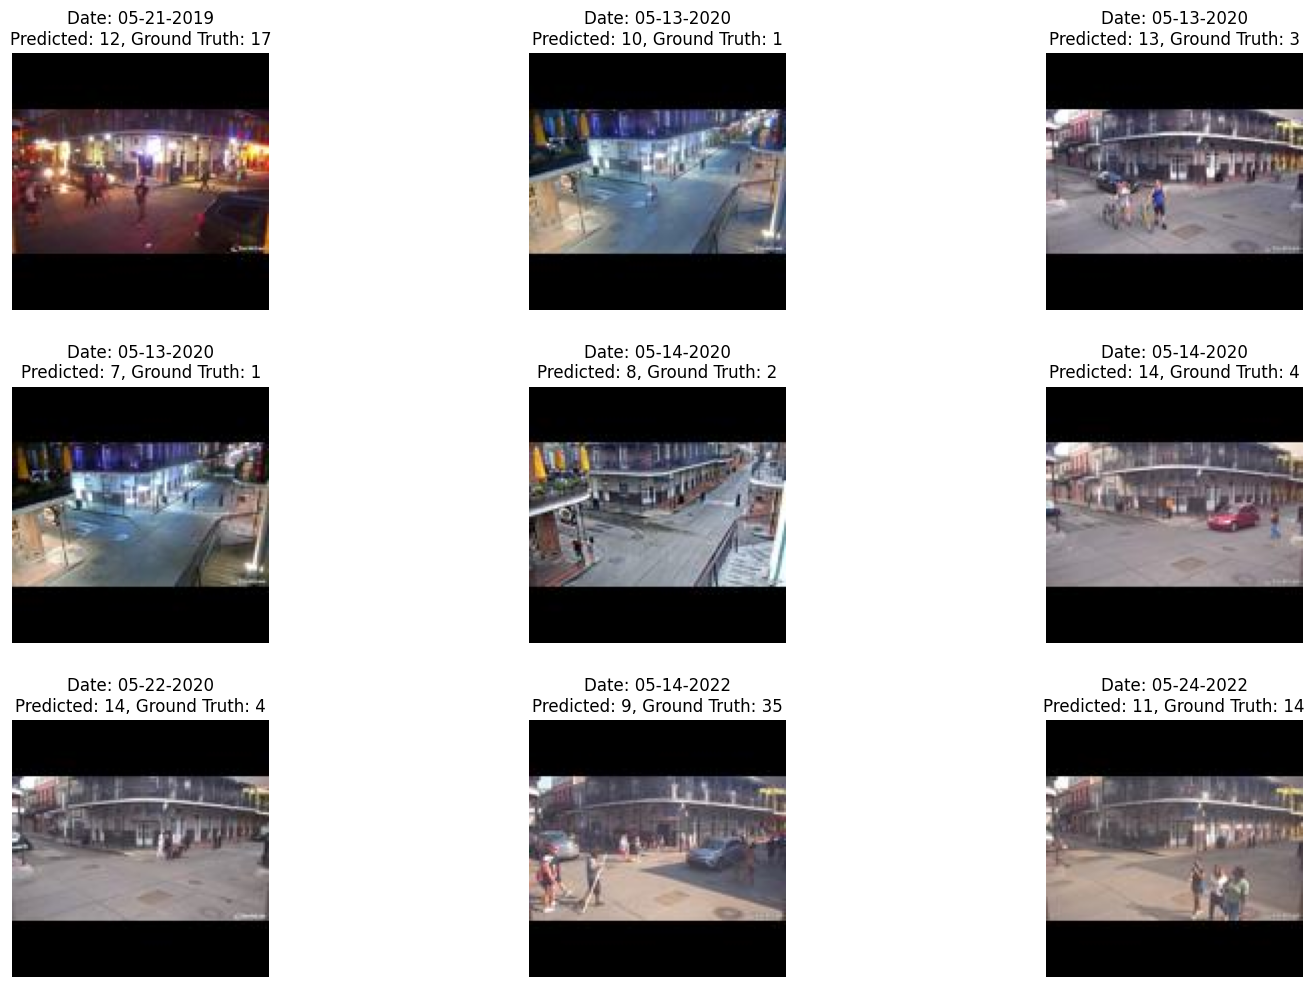

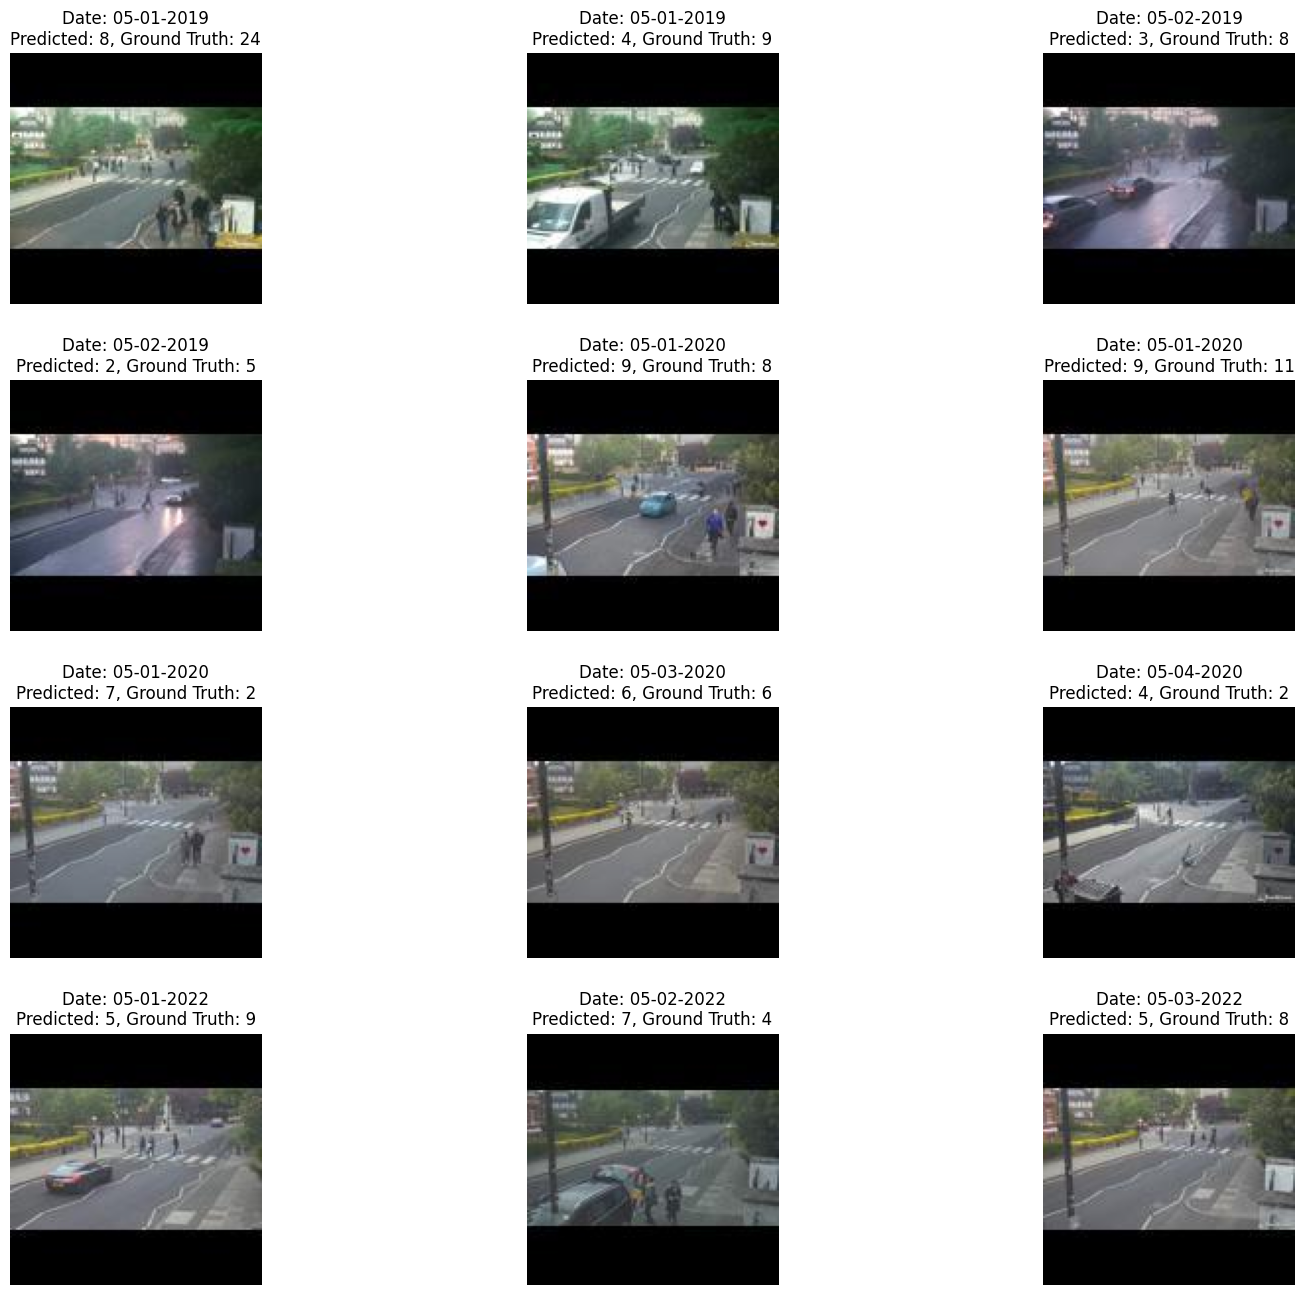

In [22]:
all_predictions = {}

ground_truth_csv_paths = {
    'New York': '/content/drive/My Drive/Manual_Annotations/ground_truth_New_York_filtered.csv',
    'New Orleans': '/content/drive/My Drive/Manual_Annotations/ground_truth_New_Orleans_filtered.csv',
    'London': '/content/drive/My Drive/Manual_Annotations/ground_truth_London_filtered.csv'
}

for city, path in ground_truth_csv_paths.items():
  visualize_ground_truth_predictions(cnn_model, path, city, all_predictions)

## Performance Metrics

In [23]:
# Extract ground truth and predicted values
ground_truths = [data['ground_truth'] for data in all_predictions.values()]
predictions = [data['predicted'] for data in all_predictions.values()]

# Calculate MAE, MSE, RMSE
mae = np.mean(np.abs(np.array(ground_truths) - np.array(predictions)))
mse = np.mean((np.array(ground_truths) - np.array(predictions)) ** 2)
rmse = np.sqrt(mse)

mae, mse, rmse

(6.433333333333334, 71.16666666666667, 8.436033823229176)